# Import dataset

In [5]:
import pandas as pd
import numpy as np
import json
from pandas.io.json import json_normalize
import pickle
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from IPython.display import display
%matplotlib inline

In [6]:
#set folder path
folder = 'data'
fd = folder
fd_km = fd

data_train_df = pd.read_pickle(fd_km + '/data_train_v1').reset_index().iloc[:,1:] #full set
data_test_df = pd.read_pickle(fd_km + '/data_test_v1').reset_index().iloc[:,1:]  

# Plot Datasetda

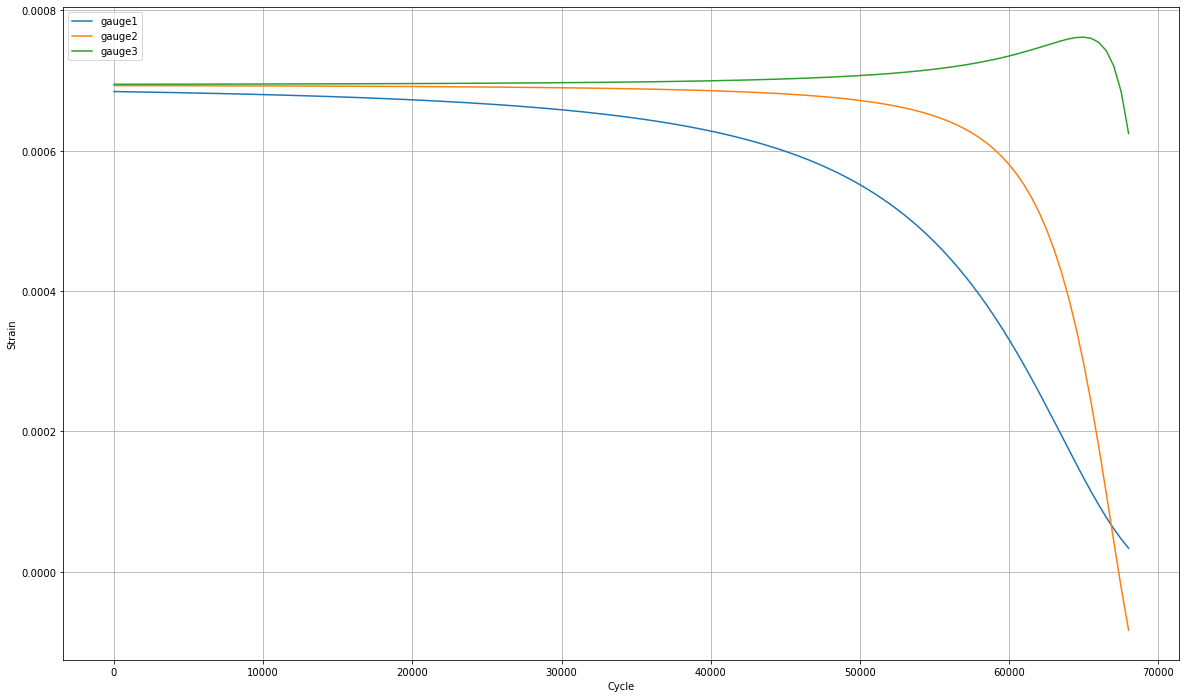

In [7]:
plt.figure(figsize=(20, 12))
plt.plot(data_train_df[data_train_df.ID == 1]['cycle'], data_train_df[data_train_df.ID == 1]['gauge1'],label= 'gauge1')
plt.plot(data_train_df[data_train_df.ID == 1]['cycle'], data_train_df[data_train_df.ID == 1]['gauge2'],label= 'gauge2')
plt.plot(data_train_df[data_train_df.ID == 1]['cycle'], data_train_df[data_train_df.ID == 1]['gauge3'], label= 'gauge3')
plt.grid()
plt.legend()
plt.xlabel('Cycle')
plt.ylabel('Strain')
plt.show()

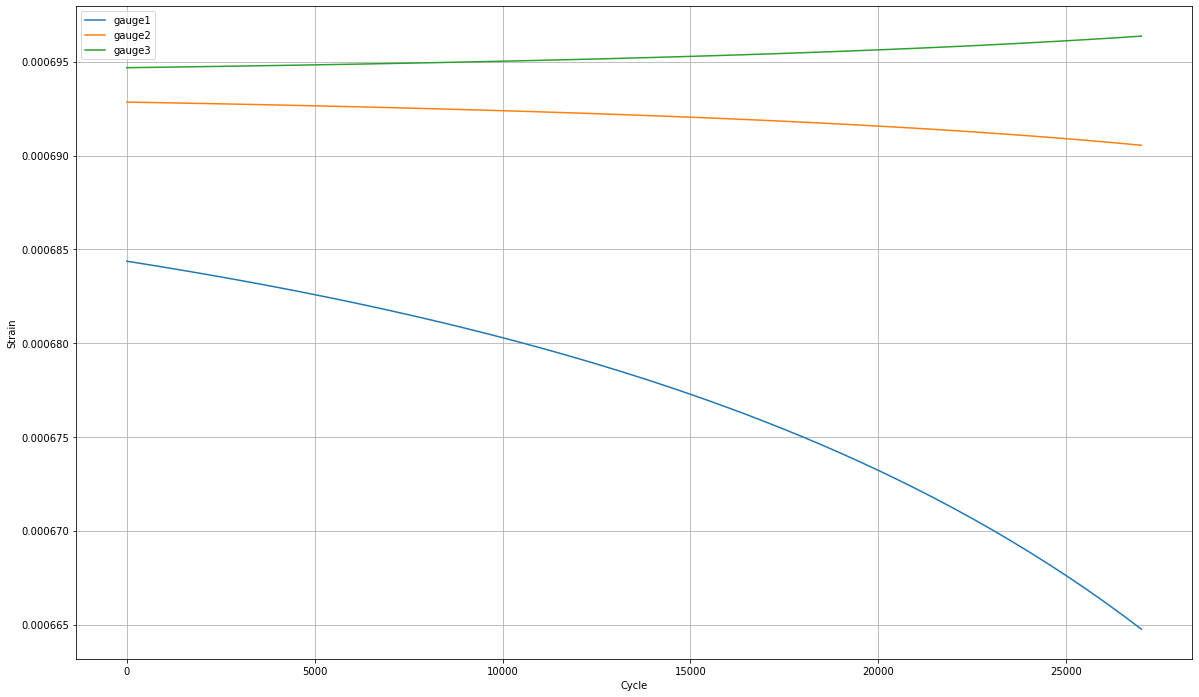

In [8]:
plt.figure(figsize=(20, 12))
plt.plot(data_test_df[data_test_df.ID == 1]['cycle'], data_test_df[data_test_df.ID == 1]['gauge1'],label= 'gauge1')
plt.plot(data_test_df[data_test_df.ID == 1]['cycle'], data_test_df[data_test_df.ID == 1]['gauge2'],label= 'gauge2')
plt.plot(data_test_df[data_test_df.ID == 1]['cycle'], data_test_df[data_test_df.ID == 1]['gauge3'], label= 'gauge3')
plt.grid()
plt.legend()
plt.xlabel('Cycle')
plt.ylabel('Strain')
plt.show()

# Categorise RUL data

In [9]:
l=0.5
nb_bins = 20 # including one extra bin for RUL>upper_bin_bound
lower_bin_bound = 0
upper_bin_bound = 80000

bins = np.linspace(lower_bin_bound**l, upper_bin_bound**l, nb_bins)**(1/l)
bins = np.append(bins, data_train_df.RUL.max())

labels=[i for i in range(bins.shape[0]-1)]

In [10]:
# Setup a plot such that only the bottom spine is shown
def setup(ax):
    ax.spines['right'].set_color('none')
    ax.spines['left'].set_color('none')
    ax.yaxis.set_major_locator(ticker.NullLocator())
    ax.spines['top'].set_color('none')
    ax.xaxis.set_ticks_position('bottom')
    ax.tick_params(which='major', width=1.00)
    ax.tick_params(which='major', length=5)
    ax.tick_params(which='minor', width=0.75)
    ax.tick_params(which='minor', length=2.5)
    ax.set_xlim(-5000, 85000)
    ax.set_ylim(0, 1)
    ax.patch.set_alpha(0.0)

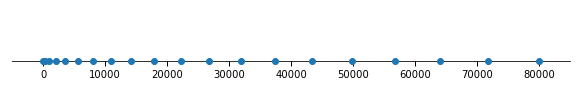

In [11]:
plt.figure(figsize=(10, 1))
n = 1
ax = plt.subplot(n, 1, 1)
setup(ax)
ax.xaxis.set_major_locator(ticker.MultipleLocator(10000))
ax.set_clip_on(False)
ax.plot(bins[:-1],np.full(bins[:-1].shape[0],0),'o', zorder=10, clip_on=False)

In [12]:
data_train_df['RUL_bin'] = pd.cut(data_train_df['RUL'], bins=bins, labels=labels)
data_test_df['RUL_bin'] = pd.cut(data_test_df['RUL'], bins=bins, labels=labels)

# Build sequences

In [13]:
#utils
data_train = data_train_df[data_train_df.ID <= 100] # Change this for 100, 500 or 1000 training structures
data_val = data_train_df[data_train_df.ID > 9900]
data_test = data_test_df

#prepare forecasting data
def gen_X_sequence(id_df, seq_length, seq_cols, timesteps_pred, type_data = None):
    """ Only sequences that meet the window-length are considered, no padding is used. This means for testing
    we need to drop those which are below the window-length. An alternative would be to pad sequences so that
    we can use shorter ones """
    
    ind_start = 0
    
    data_array = id_df[seq_cols].values
    num_elements = data_array.shape[0]
    for start, stop in zip(range(0+ind_start, num_elements-seq_length+1-timesteps_pred), range(seq_length+ind_start, num_elements+1-timesteps_pred)):
        yield data_array[start:stop, :]
 

def gen_Y_sequence(id_df, seq_length, seq_cols, timesteps_pred, type_data = None):
    """ Only sequences that meet the window-length are considered, no padding is used. This means for testing
    we need to drop those which are below the window-length. An alternative would be to pad sequences so that
    we can use shorter ones """
    
    ind_start = 0
    
    data_array = id_df[seq_cols].values
    num_elements = data_array.shape[0]
    for start, stop in zip(range(0+ind_start, num_elements-seq_length+1-timesteps_pred), range(seq_length+ind_start, num_elements+1-timesteps_pred)):
        yield data_array[stop-1, :]#data_array[start+1:stop+1, :]

In [14]:
#prepare data
seq_cols =  ['gauge'+str(i) for i in range(1,4)]
seq_cols1 =  ['RUL_bin']
sequence_length = 30
timesteps_pred = 1


#training set
seq_gen = (list(gen_X_sequence(data_train[data_train['ID']==id], sequence_length, seq_cols, timesteps_pred, type_data= 'train')) 
                   for id in data_train['ID'].unique())
# generate sequences and convert to numpy array
dbX = np.concatenate(list(seq_gen))

seq_gen = (list(gen_Y_sequence(data_train[data_train['ID']==id], sequence_length, seq_cols1, timesteps_pred, type_data= 'train')) 
                   for id in data_train['ID'].unique())
# generate sequences and convert to numpy array
dbY = np.concatenate(list(seq_gen)).reshape(-1,)

#val set
seq_gen = (list(gen_X_sequence(data_val[data_val['ID']==id], sequence_length, seq_cols, timesteps_pred, type_data= 'train')) 
                   for id in data_val['ID'].unique())
# generate sequences and convert to numpy array
dbX_val = np.concatenate(list(seq_gen))

seq_gen = (list(gen_Y_sequence(data_val[data_val['ID']==id], sequence_length, seq_cols1, timesteps_pred, type_data= 'train')) 
                   for id in data_val['ID'].unique())
# generate sequences and convert to numpy array
dbY_val = np.concatenate(list(seq_gen)).reshape(-1,)

#test set
seq_gen = (list(gen_X_sequence(data_test[data_test['ID']==id], sequence_length, seq_cols, timesteps_pred, type_data= 'train')) 
                   for id in data_test['ID'].unique())
# generate sequences and convert to numpy array
dbX_test = np.concatenate(list(seq_gen))

seq_gen = (list(gen_Y_sequence(data_test[data_test['ID']==id], sequence_length, seq_cols1, timesteps_pred, type_data= 'train')) 
                   for id in data_test['ID'].unique())
# generate sequences and convert to numpy array
dbY_test = np.concatenate(list(seq_gen)).reshape(-1,)

# Test Model

In [23]:
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from sklearn.metrics import recall_score, precision_score, f1_score
from tcn import *

In [16]:
# load model from file
loaded_json = open('models/models_tcn/500_structures/TCN_Model_adaptiveLR_1.json', 'r').read()
loadedModel = model_from_json(loaded_json, custom_objects={'TCN': TCN})

tcn_full_summary(loadedModel, expand_residual_blocks=False)

# restore weights
loadedModel.load_weights('models/models_tcn/500_structures/TCN_Model_adaptiveLR_1_weights_epoch_466_val_accuracy_0.9836335182189941.h5')

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 30, 3)]           0         
_________________________________________________________________
residual_block_0 (ResidualBl [(None, 30, 25), (None, 3 3052      
_______________________________________________________

In [35]:
dbX_test = [data_test[data_test['ID']==id][seq_cols].values[-sequence_length:] for id in data_test['ID'].unique()]
dbX_test = np.asarray(dbX_test)

dbY_test = [data_test[data_test['ID']==id][seq_cols1].values[-1] for id in data_test['ID'].unique()]
dbY_test = np.asarray(dbY_test)

In [36]:
loadedModel.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['SparseCategoricalAccuracy'])

loss, accuracy = loadedModel.evaluate(dbX_test, dbY_test, verbose=2)

4/4 - 0s - loss: 0.0411 - sparse_categorical_accuracy: 0.9800


In [40]:
dbY_test_pred = loadedModel.predict(dbX_test).argmax(axis=1)

recall = recall_score(dbY_test, dbY_test_pred, labels=labels, average=None)
precision = precision_score(dbY_test, dbY_test_pred, labels=labels, average=None)
f1 = f1_score(dbY_test, dbY_test_pred, labels=labels, average=None)

C:\Users\pajo8\anaconda3\envs\RUL-Prediction\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\pajo8\anaconda3\envs\RUL-Prediction\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\pajo8\anaconda3\envs\RUL-Prediction\lib\site-packages\sklearn\metrics\_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


In [41]:
print('loss: ' + str(loss))
print('accuracy: ' + str(accuracy))
print('recall: ' + str(recall))
print('precision: ' + str(precision))
print('f1_score: ' + str(f1))

loss: 0.04114653915166855
accuracy: 0.9800000190734863
recall: [0.         0.         0.         0.         1.         1.
 1.         0.85714286 1.         1.         1.         1.
 1.         0.95238095 1.         0.         0.         0.
 0.         0.        ]
precision: [0.         0.         0.         0.         1.         1.
 0.88888889 1.         1.         1.         1.         1.
 0.9        1.         1.         0.         0.         0.
 0.         0.        ]
f1_score: [0.         0.         0.         0.         1.         1.
 0.94117647 0.92307692 1.         1.         1.         1.
 0.94736842 0.97560976 1.         0.         0.         0.
 0.         0.        ]
